# Bowen ratio analysis

In this notebook, we calculate $\kappa$, which is defined as 
\begin{equation}
\kappa := \dfrac{\gamma \nu_{L} L}{\alpha}.
\end{equation}
The parameters on the LHS of the above were all calculated in the *CalculateSEMBModelParameters* notebook.

We will then calculate the actual Bowen ratio (or its reciprocal), as
\begin{equation}
\cal{B} := \dfrac{\cal{L}}{\cal{H}+F_{LW} + G},
\end{equation}
where $\cal{L}$ is the latent heat flux. We form a new quantity that is identical to $\cal{B}$ as
\begin{equation}
\cal{B}^* := \dfrac{d\cal{L}/dT}{\alpha},
\end{equation}
where we've taken a temperature derivative in the numerator and denominator. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import glob 
import cartopy
import cartopy.crs as ccrs 

import sys
sys.path.append("/data/keeling/a/adammb4/heatwaves-physics/src/")
from getDataProcessing import *

## $\kappa$ calculation

In [2]:
era5_PATH = "/data/keeling/a/adammb4/heatwaves-physics/data/era5/"
model_params_name = glob.glob(era5_PATH + "model_params3.nc")

model_params_ds = xr.open_dataset(model_params_name[0])

In [3]:
model_params_ds

<xarray.Dataset>
Dimensions:  (lat: 1801, long: 3600)
Coordinates:
  * long     (long) float32 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat      (lat) float32 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    alpha    (lat, long) float64 ...
    nu_L     (lat, long) float64 ...
    gamma    (lat, long) float32 ...

In [4]:
alpha_n = model_params_ds["alpha"].values
nu_L_n = model_params_ds["nu_L"].values
gamma_n = model_params_ds["gamma"].values 

lat = model_params_ds["lat"].values
long = model_params_ds["long"].values

In [5]:
L = 2.453e6 # J/kg
kappa_n = L * nu_L_n * gamma_n * alpha_n**(-1)

In [6]:
np.nanmean(kappa_n)

0.1714444546892222

In [7]:
kappa_ds = xr.Dataset({"kappa": (["lat", "long"], kappa_n),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

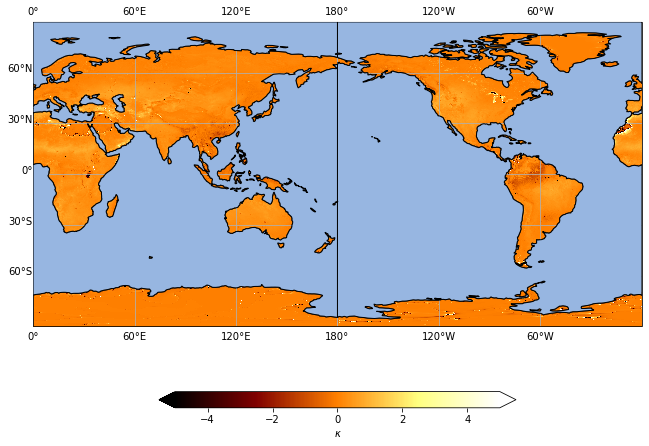

In [8]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
kappa_ds.kappa.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot', vmin=-5, vmax=5,
              cbar_kwargs={'label':'$\kappa$','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_28_2021_kappa.png", dpi=400)
fig1.savefig("../docs/figdump/10_28_2021_kappa.png", dpi=400)

# Comparing $\kappa$ to $\cal{B}^*$

First, need to calc $\cal{B}^*$, which amounts to regressing latent heat anomalies against temperature anomalies

In [9]:
latent_name = glob.glob(era5_PATH + 'latent.nc')
temp_name = glob.glob(era5_PATH + 'dewpt*')

latent_ds = xr.open_dataset(latent_name[0])
temp_ds = xr.open_dataset(temp_name[0])

latent_ds

<xarray.Dataset>
Dimensions:    (latitude: 1801, longitude: 3600, time: 122)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 1981-06-01 1981-07-01 ... 2021-07-01
Data variables:
    slhf       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-28 19:40:18 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

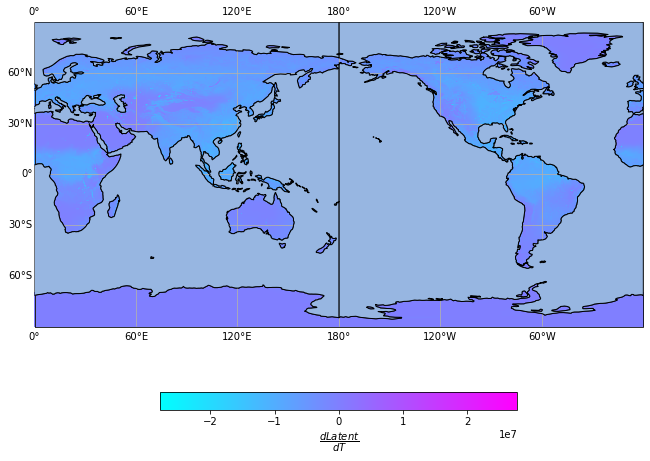

In [10]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
latent_ds.slhf.mean(axis=0).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='cool',
              cbar_kwargs={'label':r'$\dfrac{dLatent}{dT}$','shrink':0.4,'orientation':'horizontal'})

#fig1.savefig("./figures/10_28_2021_latentanom_regress_temp.png", dpi=400)
#fig1.savefig("../docs/figdump/10_28_2021_latentanom_regress_temp.png", dpi=400)

In [11]:
latent_n = latent_ds["slhf"].values * 86400**(-1)
temp_n = temp_ds['t2m'].values 

In [12]:
latent_anom = getRemove3MSeasonalCycle(latent_n)
temp_anom = getRemove3MSeasonalCycle(temp_n)

/data/keeling/a/adammb4/heatwaves-physics/src/getDataProcessing.py:128: RuntimeWarning: Mean of empty slice
  june_mean = np.nanmean(june_data, axis=0)
/data/keeling/a/adammb4/heatwaves-physics/src/getDataProcessing.py:129: RuntimeWarning: Mean of empty slice
  july_mean = np.nanmean(july_data, axis=0)
/data/keeling/a/adammb4/heatwaves-physics/src/getDataProcessing.py:130: RuntimeWarning: Mean of empty slice
  aug_mean = np.nanmean(aug_data, axis=0)


In [13]:
latent_da = xr.DataArray(data=-latent_anom, dims=["time", "lat", "long"])
temp_anom_da = xr.DataArray(data=temp_anom, dims=["time", "lat", "long"])

In [14]:
dLdT, intercept, pval, error, cov, cor = get2DLaggedRegression(temp_anom_da, latent_da, 0,0)

/data/keeling/a/adammb4/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/adammb4/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/adammb4/miniconda3/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [15]:
np.nanmean(dLdT.values)

-0.18932534672875392

In [16]:
dLdT_ds = xr.Dataset({"dLdT": (["lat", "long"], dLdT.values),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    ) 

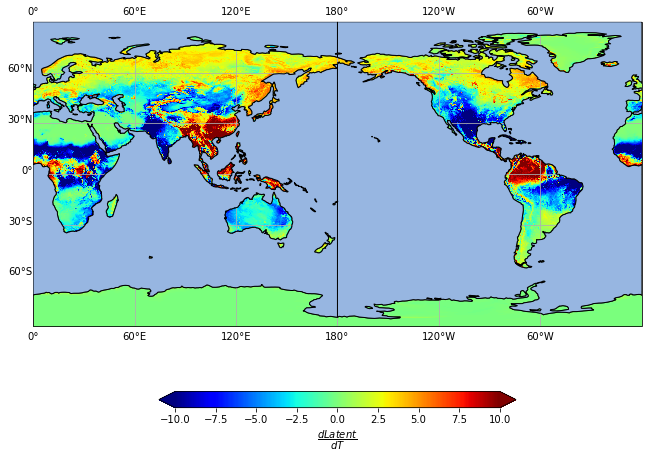

In [17]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
dLdT_ds.dLdT.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='jet', vmin=-10, vmax=10,
              cbar_kwargs={'label':r'$\dfrac{dLatent}{dT}$','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_28_2021_latentanom_regress_temp.png", dpi=400)
fig1.savefig("../docs/figdump/10_28_2021_latentanom_regress_temp.png", dpi=400)

In [18]:
comp = dLdT.values * (nu_L_n * gamma_n * L)**(-1)

In [19]:
np.nanmean(comp)

0.47850277228619115

In [20]:
comp_ds = xr.Dataset({"comp": (["lat", "long"], comp),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    ) 

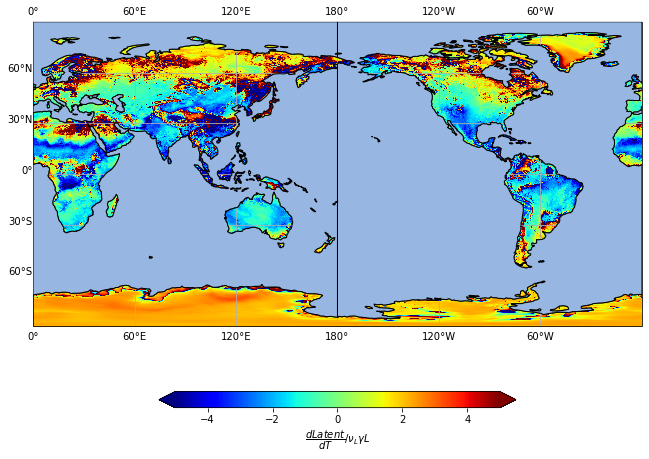

In [23]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
comp_ds.comp.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='jet', vmin=-5,vmax=5,
              cbar_kwargs={'label':r'$\dfrac{dLatent}{dT} / \nu_L \gamma L$','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_28_2021_ratio.png", dpi=400)
fig1.savefig("../docs/figdump/10_28_2021_ratio.png", dpi=400)